<a href="https://colab.research.google.com/github/DeeeTeeee/Store-Sales-Time-Series-Forecasting/blob/main/Store_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Project (Store Sales -- Time Series Forecasting)


In [22]:
# !pip install category_encoders
# !pip install squarify
# !pip install pmdarima

## Import Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpathes
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import datetime as dt
import squarify

from scipy.stats import f_oneway
from datetime import datetime
from datetime import date

from  category_encoders import BinaryEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [24]:
# # For CSV, use pandas.read_csv
# from google.colab import drive
# drive.mount('/content/drive')


## Load Data

In [25]:
# #Loading all datasets
holiday = pd.read_csv('/content/holidays_events.csv',index_col=["date"],parse_dates=["date"])
oil = pd.read_csv('/content/oil.csv', parse_dates=["date"])
stores = pd.read_csv('/content/stores.csv')
test = pd.read_csv('/content/test.csv',index_col=["date"],parse_dates=["date"])
train = pd.read_csv('/content/train.csv',index_col=["date"],parse_dates=['date'])
transactions = pd.read_csv('/content/transactions.csv',index_col=["date"],parse_dates=["date"])
sample_submission = pd.read_csv('/content/sample_submission.csv')

## Exploratory Data Analysis: EDA

### Questions

#### 1. Is the train dataset complete (has all the required dates)?

#### 2. Which dates have the lowest and highest sales for each year?

#### 3. Did the earthquake impact sales?

#### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

#### 5. Are sales affected by promotions, oil prices and holidays?



### Hypothesis

##### Null Hypothesis:  Holidays do not affect the unit store sales
##### Alternate Hypothesis:  Holidays affect the sales in the store sales

### Data Overview
Here, the following were checked:<br>
* The shape of all the datasets
* The datatypes of the columns in the datasets
* Summary statistics
* Missing values

##### Data Shape

In [26]:
# Print out the shapes of the datasets
print(f"The shape of the holiday dataset is: {holiday.shape}")
print(f"The shape of the oil dataset is: {oil.shape}")
print(f"The shape of the stores dataset is: {stores.shape}")
print(f"The shape of the test dataset is: {test.shape}")
print(f"The shape of the train dataset is: {train.shape}")
print(f"The shape of the transactions dataset is: {transactions.shape}")
print(f"The shape of the sample_submission dataset is: {sample_submission.shape}")

The shape of the holiday dataset is: (350, 5)
The shape of the oil dataset is: (1218, 2)
The shape of the stores dataset is: (54, 5)
The shape of the test dataset is: (28512, 4)
The shape of the train dataset is: (1597939, 5)
The shape of the transactions dataset is: (83488, 2)
The shape of the sample_submission dataset is: (28512, 2)


##### Datatypes

In [27]:
# Print the data types of each dataset
def show_data_type(dataset_name, dataset):
    print(f"Data types for {dataset_name}:")
    print(dataset.dtypes)
    print('_' * 50)

show_data_type('Stores', stores)
show_data_type('Train', train)
show_data_type('Test', test)
show_data_type('Transactions', transactions)
show_data_type('Oil', oil)
show_data_type('Holiday', holiday)
show_data_type('Sample_Submission', sample_submission)



Data types for Stores:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
__________________________________________________
Data types for Train:
id               int64
store_nbr        int64
family          object
sales          float64
onpromotion    float64
dtype: object
__________________________________________________
Data types for Test:
id              int64
store_nbr       int64
family         object
onpromotion     int64
dtype: object
__________________________________________________
Data types for Transactions:
store_nbr       int64
transactions    int64
dtype: object
__________________________________________________
Data types for Oil:
date          datetime64[ns]
dcoilwtico           float64
dtype: object
__________________________________________________
Data types for Holiday:
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
_______

##### Summary Statistics

In [28]:
#checking for the summary of the datasets:
datasets = {'holiday': holiday, 'oil': oil, 'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'sample_submission' : sample_submission}

for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset summary statistics:\n")
    print(data.describe())
    print('_' * 50)


Holiday dataset summary statistics:

           type    locale locale_name description transferred
count       350       350         350         350         350
unique        6         3          24         103           2
top     Holiday  National     Ecuador    Carnaval       False
freq        221       174         174          10         338
__________________________________________________

Oil dataset summary statistics:

        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
__________________________________________________

Stores dataset summary statistics:

       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
__________________________________________________

Trai

##### Missing Values

In [29]:
# showing missing values in all dataset using a function

datasets = {'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'oil': oil, 'holiday': holiday, 'sample_submission' : sample_submission}

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in {name} dataset:")
        print(data.isnull().sum())
        print('_' * 50)

show_missing_values(datasets)


Missing values in stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
__________________________________________________
Missing values in train dataset:
id             0
store_nbr      0
family         0
sales          1
onpromotion    1
dtype: int64
__________________________________________________
Missing values in test dataset:
id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64
__________________________________________________
Missing values in transactions dataset:
store_nbr       0
transactions    0
dtype: int64
__________________________________________________
Missing values in oil dataset:
date           0
dcoilwtico    43
dtype: int64
__________________________________________________
Missing values in holiday dataset:
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
__________________________________________________
Missing values in sample_sub

#### Comment:
* Missing data was found in the oil datasets.

#### Approach:
* The missing data were to be replaced by the mean value per month.<br> The rationale was to represent the missing values properly by the values over the month period.




In [30]:
#replacing the nan with the mean of each month of its year
for year in range(2013, 2023):
    for month in range(1, 13):
        mask = (oil['date'].dt.month == month) & (oil['date'].dt.year == year)
        mean = oil.loc[mask, 'dcoilwtico'].mean()
        oil.loc[mask, 'dcoilwtico'] = oil.loc[mask, 'dcoilwtico'].fillna(mean)



In [31]:
# Print the missing values in the dataset again to confirm that there are no missing values left
print(oil.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


### Merging Data

In [32]:
# combine the datasets on common columns one after the other
merged_data1 = pd.merge(train, transactions, how='outer', on=['date', 'store_nbr'])
merged_data2 = pd.merge(merged_data1, holiday, how='outer', on='date')
merged_data3 = pd.merge(merged_data2, oil, how='outer', on='date')
merged_data = pd.merge(merged_data3, stores, how='outer', on='store_nbr')

In [33]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659855 entries, 0 to 1659854
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          1659855 non-null  datetime64[ns]
 1   id            1617541 non-null  float64       
 2   store_nbr     1659775 non-null  float64       
 3   family        1617541 non-null  object        
 4   sales         1617540 non-null  float64       
 5   onpromotion   1617540 non-null  float64       
 6   transactions  1453723 non-null  float64       
 7   type_x        243104 non-null   object        
 8   locale        243104 non-null   object        
 9   locale_name   243104 non-null   object        
 10  description   243104 non-null   object        
 11  transferred   243104 non-null   object        
 12  dcoilwtico    1187775 non-null  float64       
 13  city          1659775 non-null  object        
 14  state         1659775 non-null  object        
 15

##### Renaming Columns

* Two columns had to be renamed.
* 'type_x' column was changed to holiday_type
* 'type_y' column was changed to store_type

In [34]:
#Renaming Columns
merged_data = merged_data.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})
merged_data.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0


In [35]:
merged_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1617541.0,798375.313793,460428.792170,0.00,397257.00,799860.000000,1197117.00,1597938.00
store_nbr,1659775.0,27.488335,15.580187,1.00,14.00,27.000000,41.00,54.00
sales,1617540.0,275.229050,889.023450,0.00,0.00,3.000000,142.00,46271.00
onpromotion,1617540.0,0.482689,4.706615,0.00,0.00,0.000000,0.00,209.00
transactions,1453723.0,1733.409008,975.758259,5.00,1076.00,1425.000000,2180.00,8359.00
dcoilwtico,1187775.0,86.530478,20.283753,26.19,74.55,94.756667,101.39,110.62
cluster,1659775.0,8.479983,4.650161,1.00,4.00,8.000000,13.00,17.00


#### Missing Values after merge

In [36]:
merged_data.isna().sum()/len(merged_data)*100

date             0.000000
id               2.549259
store_nbr        0.004820
family           2.549259
sales            2.549319
onpromotion      2.549319
transactions    12.418675
holiday_type    85.353901
locale          85.353901
locale_name     85.353901
description     85.353901
transferred     85.353901
dcoilwtico      28.441039
city             0.004820
state            0.004820
store_type       0.004820
cluster          0.004820
dtype: float64

#### Approach:
* Drop missing values in sales column
* Create new category for missing values in holidays

In [37]:
#drop missing values in sales
merged_data.dropna(subset=['sales'],inplace=True)

In [38]:
#All unique columns in the holiday column
merged_data['holiday_type'].unique()

#Replacing missing values with a new category
merged_data['holiday_type'].replace(np.nan,'Not Holiday', inplace=True)



In [39]:
merged_data.isna().sum()

date                  0
id                    0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     206052
holiday_type          0
locale          1382316
locale_name     1382316
description     1382316
transferred     1382316
dcoilwtico       459756
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

### Analysis

### 1. Is the train dataset complete (has all the required dates)?

In [40]:
# Create a date range from the first date to the last date in the series
date_range = pd.date_range(start=train.index.min(), end=train.index.max())

# Check if there are any dates in the range that are not in the index
missing_dates = date_range.difference(train.index)

if len(missing_dates) == 0:
    print("The time series is complete.")
else:
    print("The time series is not complete. The following dates are missing:")
    print(missing_dates)

The time series is not complete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25'], dtype='datetime64[ns]', freq=None)


### 2.  Which dates have the lowest and highest sales for each year?

In [41]:
merged_data['year'] = pd.to_datetime(merged_data['date']).dt.year



#Group merged_data by year and date
grouped_data = merged_data.groupby(['year', 'date'])

#Calculate total sales for each date
sales_by_date = grouped_data['sales'].sum()


# Putting everything in a dataframe
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
lowest_sales = pd.DataFrame(sales_by_date.groupby('year').nsmallest(1))
highest_sales = pd.DataFrame(sales_by_date.groupby('year').nlargest(1))



# # Print dates with lowest and highest sales for each year
# # for year in merged_data['year'].unique():
# #     print("Year:", year)
# # print("Lowest sales:", lowest_sales['sales'])
# # print("Highest sales:", highest_sales['sales'])
# # print("-" * 50)


In [42]:
#Dates with highest sales
highest_sales

,,,sales
year,year,date,
2013,2013,2013-12-22,"1,392,590.294"
2014,2014,2014-12-22,"2,016,286.692"
2015,2015,2015-06-07,"1,070,695.918"


In [43]:
#Dates with lowest sales
lowest_sales

,,,sales
year,year,date,
2013,2013,2013-01-01,"2,511.619"
2014,2014,2014-01-01,"8,602.065"
2015,2015,2015-01-01,"12,773.617"


In [44]:
# Group the merged_data by year and date, and calculate the minimum and maximum sales for each date
sales_by_date = merged_data.groupby(['year', 'date'])['sales'].agg(['min', 'max'])

# Create a slide object
slide = widgets.Output()

# Loop through each year, and plot the minimum and maximum sales for each date as two lines
for year in sales_by_date.index.get_level_values('year').unique():
    data = sales_by_date.loc[year]
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(data.index.get_level_values('date'), data['min'], label=f'Min Sales {year}')
    ax.plot(data.index.get_level_values('date'), data['max'], label=f'Max Sales {year}')
    ax.set_title(f'Lowest and Highest Sales for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()
    # Display the figure in the slide
    with slide:
        display(fig)
    plt.close(fig)

# Display the slide
display(slide)


Output()

#### Insights:
 * From 2013 to 2015, the highest sales have been recorded in December.
 * However, the trends changed in 2016 and 2017 where the highest sales were recorded in June.
 * Perhaps, more promotions were carried out in June as compared to December

### 3. Did the earthquake impact sales?

 A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [45]:
# merged_data[merged_data['date'] == '2016-04-16']['sales'].sum()
date = '2016-04-16'
sales_sum = merged_data[merged_data['date'] == date]['sales'].sum()
print("The sales for the date {} is ${:,.2f}".format(date, sales_sum))


The sales for the date 2016-04-16 is $0.00


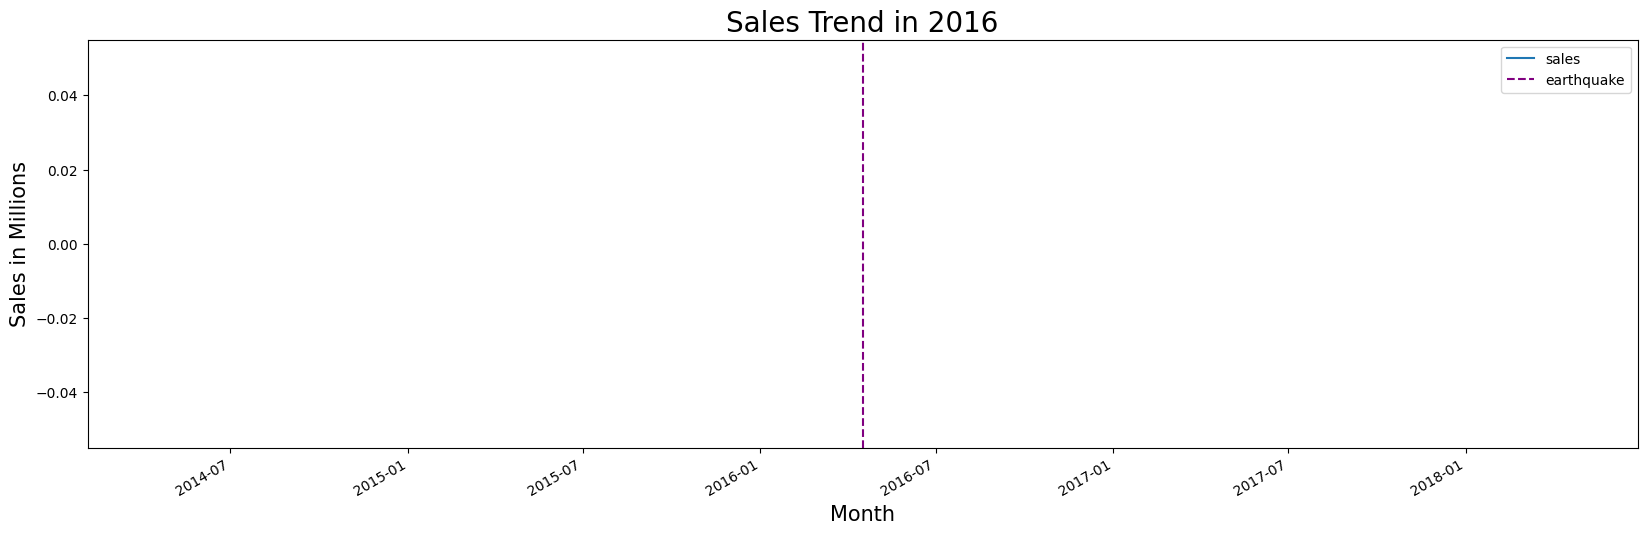

In [46]:
#define earthquake date
earthquake = [pd.to_datetime('2016-04-16')]

#Obtain 2016 dataset
data16 = merged_data[merged_data['year'] ==2016]

#Plotting
ax = data16.groupby(['date'],as_index=False)['sales'].sum().plot(
    'date', 'sales', figsize=(20,6))
ax.axvline(earthquake, color='purple', linestyle='--')
ax.legend(['sales', 'earthquake'])
plt.title('Sales Trend in 2016',fontsize = 20)
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Sales in Millions', fontsize=15);

#### Insights
From the Graph:
* Sales were on a steady rise from previous weeks prior the earthquake.
* A few days after the earthquake, sales took a dip but rose steadily for about a week and suffered a major dip until May.


### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

#### Collective grouping of cluster, city,state,type by transactions made

In [47]:
# Here, the stores and transactions were merged to help analysis
merged = pd.merge(stores, transactions, on='store_nbr')

# group the merged dataset by cluster, city, state, and type and calculate the sum of transactions for each group
grouped = merged.groupby(['cluster', 'city', 'state', 'type'])['transactions'].sum()

# print the grouped data
print(grouped)


cluster  city           state                           type
1        Daule          Guayas                          D        2485687
         Guayaquil      Guayas                          D        3568206
         Salinas        Santa Elena                     D        1520362
2        Cuenca         Azuay                           D        3284365
3        El Carmen      Manabi                          C        1451290
         Guayaquil      Guayas                          C        2236356
         Machala        El Oro                          C        2181195
         Playas         Guayas                          C        1123889
         Quevedo        Los Rios                        C        1743003
         Santo Domingo  Santo Domingo de los Tsachilas  C        1464498
4        Loja           Loja                            D        2867052
         Machala        El Oro                          D        1764146
         Santo Domingo  Santo Domingo de los Tsachilas  D      

#### Group transactions made by city

In [48]:
# Aggregate sales data by city
sales_by_city = merged.groupby('city')['transactions'].sum().reset_index().sort_values(by = 'transactions', ascending = False)
sales_by_city

,city,transactions
18,Quito,70999057
8,Guayaquil,16546295
0,Ambato,6172615
3,Cuenca,5673847
21,Santo Domingo,4655266
2,Cayambe,3972488
13,Machala,3945341
10,Latacunga,3531356
12,Loja,2867052
4,Daule,2485687


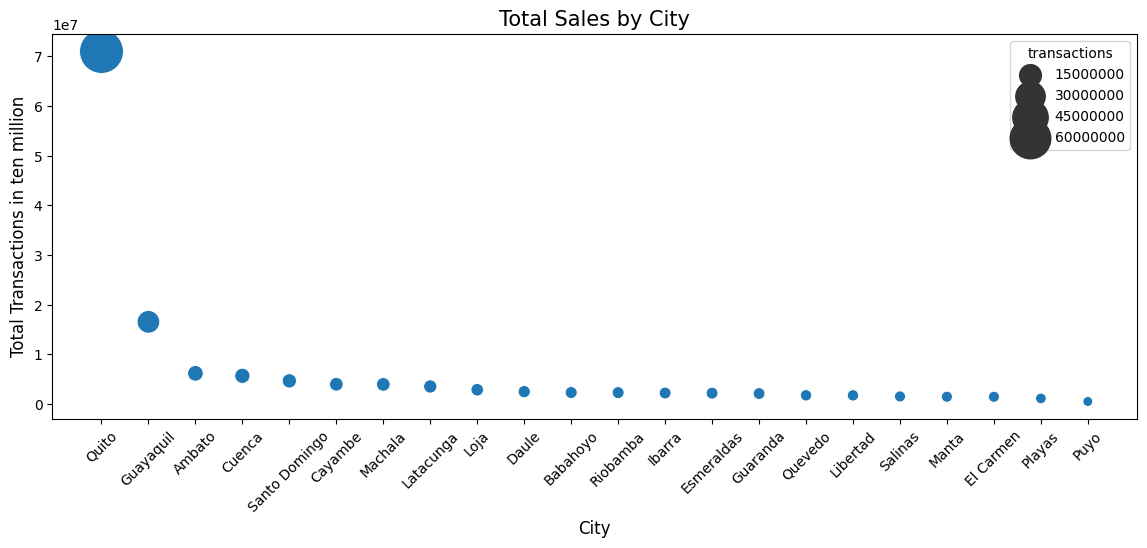

In [49]:
# Create bubble plot
plt.figure(figsize=(14,5))
sns.scatterplot(x='city', y='transactions', size='transactions', sizes=(50, 1000), data=sales_by_city, palette='Set2')
plt.title('Total Sales by City', fontsize=15)
plt.xlabel('City',fontsize=12)
plt.ylabel('Total Transactions in ten million',fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Insights

* The City Quita recorded the highest sale transactions with Puyo recording the lowest

#### Group transactions by State

In [50]:
# Group merged dataset by state and sum transactions
state_transactions = merged.groupby('state')['transactions'].sum().reset_index().sort_values(by = 'transactions', ascending = False)
state_transactions

,state,transactions
12,Pichincha,74971545
6,Guayas,21894000
15,Tungurahua,6172615
0,Azuay,5673847
14,Santo Domingo de los Tsachilas,4655266
9,Los Rios,4049047
4,El Oro,3945341
3,Cotopaxi,3531356
10,Manabi,2906765
8,Loja,2867052


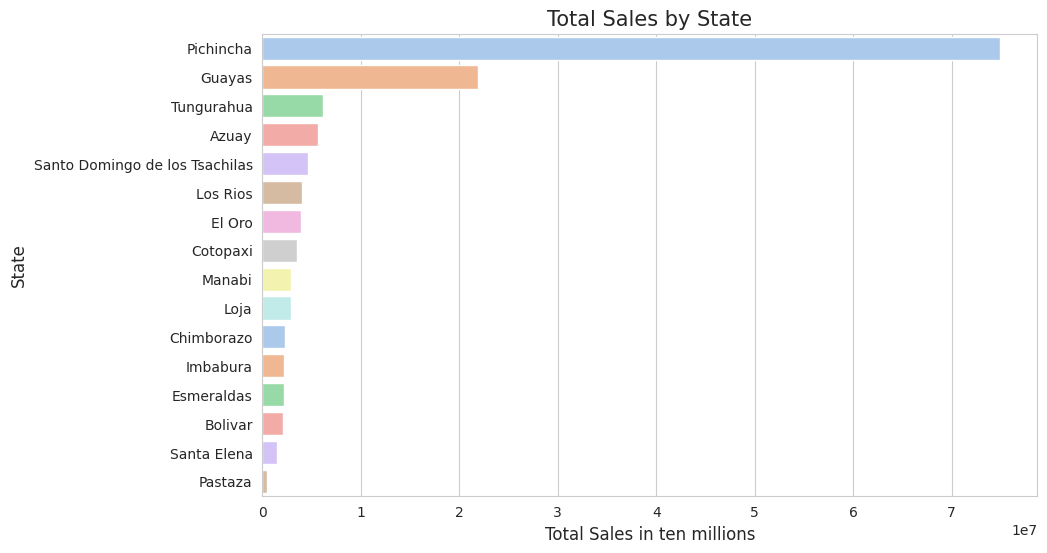

In [51]:
#Create a horizontal bar chart with Seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(data=state_transactions,x ='transactions',y ='state', palette ='pastel')
plt.title('Total Sales by State',fontsize =15)
plt.xlabel('Total Sales in ten millions', fontsize =12)
plt.ylabel('State',fontsize =12)
plt.show()


#### Insights

The state with the highest sale transsactions is Pinchincha with Pastaza recording the lowest number of transactions

#### Group transactions by store

In [52]:
trans_store = merged.groupby('type')['transactions'].sum().reset_index()

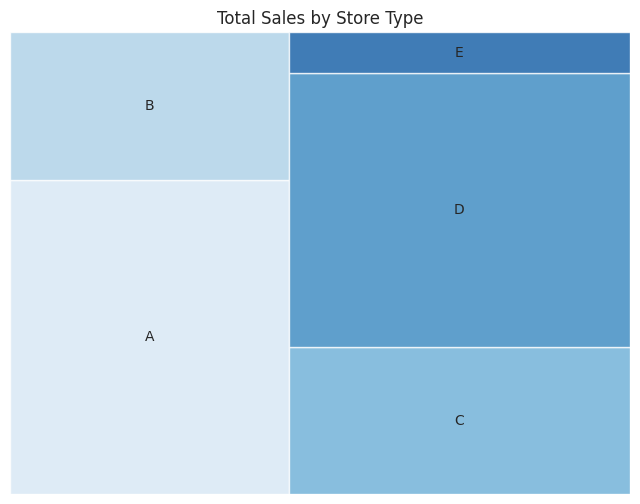

In [53]:
# Set up the color gradient
colors = sns.color_palette('Blues', len(trans_store))
color_map = dict(zip(trans_store['type'], colors))

# Create the treemap
fig, ax = plt.subplots(figsize=(8, 6))
squarify.plot(sizes=trans_store['transactions'], label=trans_store['type'], alpha=0.8, color=[color_map[type] for type in trans_store['type']])
plt.axis('off')
plt.title('Total Sales by Store Type')
plt.show()


#### Insights

The store type D was found to record the highest number of transactions

### 5. Are sales affected by promotions, oil prices and holidays?

In [54]:
# Calculate the correlation between sales and promotions
corr1 = merged_data['sales'].corr(merged_data['onpromotion'])
corr2 = merged_data['sales'].corr(merged_data['dcoilwtico'])

# Print the correlation coefficient
print('Correlation coefficient, Promotion:', corr1)
print('Correlation coefficient, Sales:', corr2)

Correlation coefficient, Promotion: 0.1926386873171909
Correlation coefficient, Sales: -0.035095221600241394


#### Insights

From the values obtained:
* Sales is positively correlated with promotion, thus an increase in promotion products may increase sales.
* However, the relationship is quite weak.
* Also, it can be deduced that the oil prices have a negative correlation with sales, thus, an increase in oil prices will may decrease sales at the stores due to increased prices which checks consumer spending.
* However, there relationship is very weak

#### Hypothesis for holiday column using ANOVA test

In [55]:
holiday_list = merged_data.groupby('holiday_type')['sales'].apply(list)
Anova_results = f_oneway(*holiday_list)
print(Anova_results)

F_onewayResult(statistic=132.39180606779658, pvalue=2.8180234280726913e-168)


#### Insights
The p-value is less than the significant level 0.05 so we reject the null hypothesis. That is, holiday columns are correlated with the sales made. Thus, sales are affected by holidays

### Feature Processing

In [56]:
#drop unnecessary columns
merged_data = merged_data.drop(columns=['id','locale', 'locale_name', 'description', 'transferred'])

In [57]:
#drop columns for univariate analysis
merged_data1 = merged_data.drop(columns=['store_nbr','family','state','onpromotion','transactions','city','dcoilwtico','holiday_type','cluster','year','store_type'])

### Feature Engineering

In [58]:
def getDateFeatures(df,date):
    df['month'] = df['date'].dt.month
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['day'] = df['date'].dt.day
    df['is_weekend'] = df['date'].dt.isocalendar().week
    df['day_of_the_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)

    return df

In [59]:
merged_data = getDateFeatures(merged_data, 'date')

In [60]:
merged_data

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,state,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,2013-01-01,1.000,AUTOMOTIVE,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
1,2013-01-01,1.000,BABY CARE,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
2,2013-01-01,1.000,BEAUTY,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
3,2013-01-01,1.000,BEVERAGES,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
4,2013-01-01,1.000,BOOKS,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658968,2015-06-17,9.000,POULTRY,372.736,0.000,"1,959.000",Not Holiday,59.890,Quito,Pichincha,...,2015,6,0,0,17,25,168,2,0,0
1658969,2015-06-17,9.000,PREPARED FOODS,61.000,9.000,"1,959.000",Not Holiday,59.890,Quito,Pichincha,...,2015,6,0,0,17,25,168,2,0,0
1658970,2015-06-17,9.000,PRODUCE,"1,267.097",3.000,"1,959.000",Not Holiday,59.890,Quito,Pichincha,...,2015,6,0,0,17,25,168,2,0,0
1658971,2015-06-17,9.000,SCHOOL AND OFFICE SUPPLIES,5.000,0.000,"1,959.000",Not Holiday,59.890,Quito,Pichincha,...,2015,6,0,0,17,25,168,2,0,0


### Binary Encoding

In [61]:
# Import necessary libraries
from  category_encoders import BinaryEncoder

# Instantiate BinaryEncoder
ce = BinaryEncoder

encoder = ce(cols=['family','city','state','store_type','cluster','holiday_type'], drop_invariant=True)
merged_data = encoder.fit_transform(merged_data)

In [62]:
merged_data.sample(8)

,date,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
1196756,2015-04-22,44.000,0,0,0,0,0,1,14.000,0.000,...,2015,4,0,0,22,17,112,2,0,0
90852,2015-05-30,11.000,0,1,0,0,1,1,698.000,0.000,...,2015,5,0,0,30,22,150,2,0,0
76665,2014-03-31,11.000,0,1,0,1,1,0,31.000,0.000,...,2014,3,0,1,31,14,90,1,0,1
390348,2014-09-29,20.000,0,1,1,1,0,0,0.000,0.000,...,2014,9,0,0,29,40,272,3,0,0
162109,2013-09-05,14.000,0,0,0,0,1,0,0.000,0.000,...,2013,9,0,0,5,36,248,3,0,0
810483,2013-11-23,33.000,0,0,1,1,1,0,2.000,0.000,...,2013,11,0,0,23,47,327,4,0,0
1120892,2014-02-14,42.000,0,1,0,1,0,0,0.000,0.000,...,2014,2,0,0,14,7,45,1,0,0
1258921,2015-05-12,46.000,0,1,1,0,1,0,532.000,5.000,...,2015,5,0,0,12,20,132,2,0,0


### Feature Drop

In [63]:
# drop columns
merged_data = merged_data.drop(columns=['date'])

### Scaling

In [64]:
from sklearn.preprocessing import StandardScaler

# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['store_nbr','sales', 'transactions', 'dcoilwtico', 'year','month','is_month_start','is_month_end','day','is_weekend','day_of_the_year','quarter','is_quarter_start','is_quarter_end']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

In [65]:
merged_data

,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,transactions,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,-1.700,0,0,0,0,0,1,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
1,-1.700,0,0,0,0,1,0,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
2,-1.700,0,0,0,0,1,1,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
3,-1.700,0,0,0,1,0,0,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
4,-1.700,0,0,0,1,0,1,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658968,-1.187,0,1,1,1,0,1,0.110,0.000,0.229,...,1.655,0.019,-0.185,-0.182,0.159,0.071,0.030,-0.285,-0.106,-0.100
1658969,-1.187,0,1,1,1,1,0,-0.241,9.000,0.229,...,1.655,0.019,-0.185,-0.182,0.159,0.071,0.030,-0.285,-0.106,-0.100
1658970,-1.187,0,1,1,1,1,1,1.116,3.000,0.229,...,1.655,0.019,-0.185,-0.182,0.159,0.071,0.030,-0.285,-0.106,-0.100
1658971,-1.187,1,0,0,0,0,0,-0.304,0.000,0.229,...,1.655,0.019,-0.185,-0.182,0.159,0.071,0.030,-0.285,-0.106,-0.100


### Spliting the Dataset

In [66]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_data.drop('sales', axis=1), merged_data['sales'], test_size=0.2, random_state=42)

In [67]:
# split for the stats model
combined = merged_data1.groupby('date')['sales'].sum().reset_index()
combined =combined.set_index('date')

train_data = combined[1:len(combined)-337]
test_data = combined[len(combined)-337:]

In [68]:
merged_data.dropna(subset=['sales'], inplace=True)

In [69]:
merged_data.head(2)

,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,transactions,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,-1.700,0,0,0,0,0,1,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100
1,-1.700,0,0,0,0,1,0,-0.310,0.000,NaN,...,-1.057,-1.446,5.409,-0.182,-1.663,-1.550,-1.572,-1.191,9.475,-0.100


#### Imputation

In [70]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='mean')
col = ['transactions','dcoilwtico']
# impute the missing values in your data
X_train[col] = imputer.fit_transform(X_train[col])
X_test[col] = imputer.transform(X_test[col])

### Modelling

### Univariate Time Forecasting

Approah:

Use AR, ARIMA and SARIMA models

#### AR Model

##### Autocorrelation and Partial Autocorrelation


<Figure size 500x800 with 0 Axes>

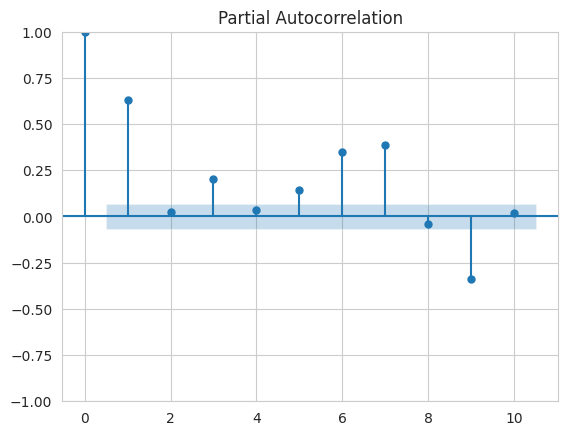

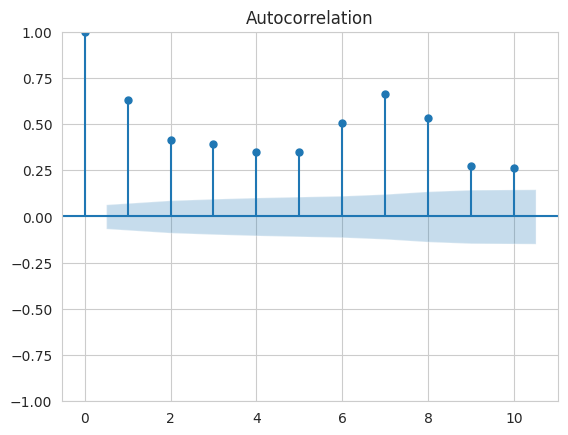

In [71]:
plt.figure(figsize=(5,8))
pacf = plot_pacf(combined['sales'],lags =10)
acf = plot_acf(combined['sales'],lags =10)

##### Stationarity Test

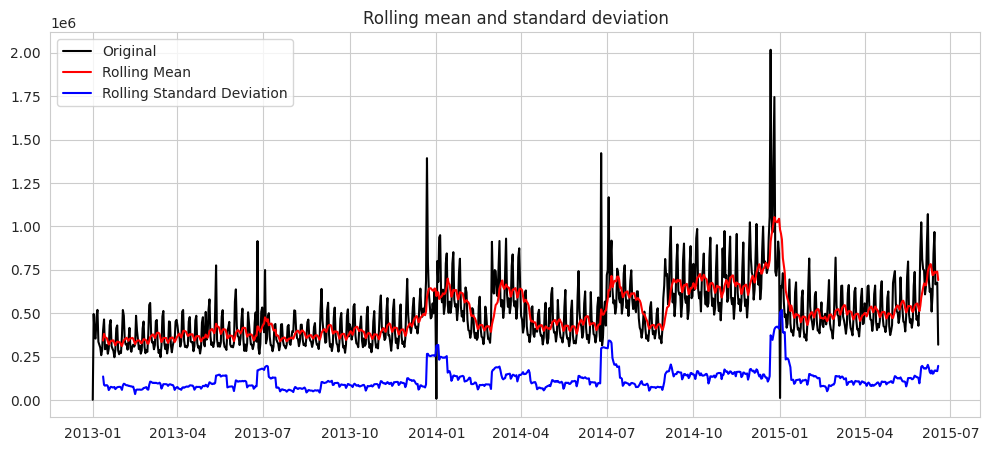

In [72]:
plt.figure(figsize=(12,5))
rmean=combined['sales'].rolling(window=12).mean()
rstd=combined['sales'].rolling(window=12).std()
# print(rmean,rstd)
orig=plt.plot(combined['sales'], color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show();

###### Comment:
From the graph above, the rolling mean and rolling standard deviation is constant, thus the dataset can be said to be stationary

#### Ar Model

In [73]:
model1 =AutoReg(train_data, lags=5).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                  559
Model:                     AutoReg(5)   Log Likelihood               -7295.190
Method:               Conditional MLE   S.D. of innovations         126661.577
Date:                Wed, 14 Jun 2023   AIC                          14604.380
Time:                        10:45:39   BIC                          14634.600
Sample:                             5   HQIC                         14616.185
                                  559                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.519e+05   2.28e+04      6.671      0.000    1.07e+05    1.97e+05
sales.L1       0.5385      0.042     12.721      0.000       0.456       0.622
sales.L2      -0.0901      0.048     -1.873      0.061      -0.184       0.004
sales.L3       0.1195      0.048      2.488      0.013       0.025       0.214
sales.L4       0.0024      0.048      0.049      0.961      -0.092       0.097
sales.L5       0.0835      0.043      1.964      0.050       0.000       0.167
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2361           -0.0000j            1.2361           -0.0000
AR.2            0.6418           -1.5399j            1.6683           -0.1871
AR.3            0.6418           +1.5399j            1.6683            0.1871
AR.4           -1.2741           -1.3635j            1.8662           -0.3696
AR.5           -1.2741           +1.3635j            1.8662            0.3696
-----------------------------------------------------------------------------
"""

##### Predictions

In [74]:
Ar_pred = model1.predict(start =len(train_data),
                       end = len(train_data) +len(test_data)-1,
                       dynamic =False)

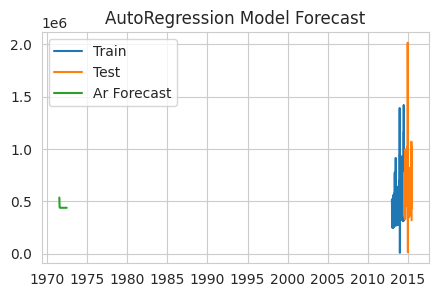

In [75]:
plt.figure(figsize=(5,3))
plt.plot(train_data['sales'], label ='Train')
plt.plot(test_data['sales'], label ='Test')
plt.plot(Ar_pred, label ='Ar Forecast')
plt.legend(loc='best')
plt.title('AutoRegression Model Forecast')
plt.show;

##### Evaluation

In [76]:
mse = mean_squared_error(test_data,Ar_pred)
msle = mean_squared_log_error(test_data, Ar_pred)
rmse =np.sqrt(mse).round(2)
rmsle =np.sqrt(msle).round(2)

In [77]:
results =pd.DataFrame([['AR',mse, msle,rmse,rmsle]], columns =['Model','mse','msle','rmse','rmsle'])

results

,Model,mse,msle,rmse,rmsle
0,AR,"62,117,015,608.195",0.186,"249,232.850",0.430


#### ARIMA

In [78]:
stepwise_fit = auto_arima(train_data['sales'], trace =True,suppress_warning =True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14654.781, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14858.175, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14831.422, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14731.267, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14856.177, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14665.376, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14670.115, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14661.616, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14559.768, Time=1.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14660.325, Time=0.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14559.727, Time=1.66 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=14543.541, Time=1.89 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=14576.239, Time=1.91 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=14525.685, Time=4.29 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  559
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -7225.384
Date:                Wed, 14 Jun 2023   AIC                          14472.768
Time:                        10:46:16   BIC                          14520.336
Sample:                             0   HQIC                         14491.345
                                - 559                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8601      0.069     12.421      0.000       0.724       0.996
ar.L2         -1.4712      0.063    -23.530      0.000      -1.594      -1.349
ar.L3          0.8641      0.099      8.731      0.000       0.670       1.058
ar.L4         -1.0224      0.056    -18.310      0.000      -1.132      -0.913
ar.L5          0.0666      0.060      1.109      0.267      -0.051       0.184
ma.L1         -1.5090      0.062    -24.298      0.000      -1.631      -1.387
ma.L2          1.8658      0.092     20.332      0.000       1.686       2.046
ma.L3         -1.6715      0.113    -14.838      0.000      -1.892      -1.451
ma.L4          1.3724      0.082     16.796      0.000       1.212       1.533
ma.L5         -0.6776      0.049    -13.825      0.000      -0.774      -0.582
sigma2      1.298e+10   6.88e-12   1.89e+21      0.000     1.3e+10     1.3e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             26830.96
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             3.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+36. Standard errors may be unstable.
"""

In [79]:
model2 = ARIMA(train_data, order=(4,1,3))
model_fit = model2.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  559
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -7261.979
Date:                Wed, 14 Jun 2023   AIC                          14539.959
Time:                        10:46:17   BIC                          14574.553
Sample:                             0   HQIC                         14553.469
                                - 559                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2133      0.050     24.257      0.000       1.115       1.311
ar.L2         -1.1744      0.068    -17.377      0.000      -1.307      -1.042
ar.L3          0.2393      0.063      3.827      0.000       0.117       0.362
ar.L4         -0.2090      0.039     -5.393      0.000      -0.285      -0.133
ma.L1         -1.9243      0.041    -46.766      0.000      -2.005      -1.844
ma.L2          1.8184      0.057     32.019      0.000       1.707       1.930
ma.L3         -0.7040      0.038    -18.542      0.000      -0.778      -0.630
sigma2      1.255e+10   7.99e-12   1.57e+21      0.000    1.26e+10    1.26e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):             17403.06
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             3.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.18e+36. Standard errors may be unstable.
"""

##### Prediction

In [80]:
Arima_pred = model_fit.predict(start =len(train_data),
                       end = len(train_data) +len(test_data)-1,
                       typ ='levels')

print(Arima_pred)

559   607,639.966
560   630,194.250
561   651,454.079
562   666,077.970
563   654,891.230
          ...    
891   634,203.754
892   628,277.564
893   625,003.338
894   626,826.608
895   632,319.652
Name: predicted_mean, Length: 337, dtype: float64


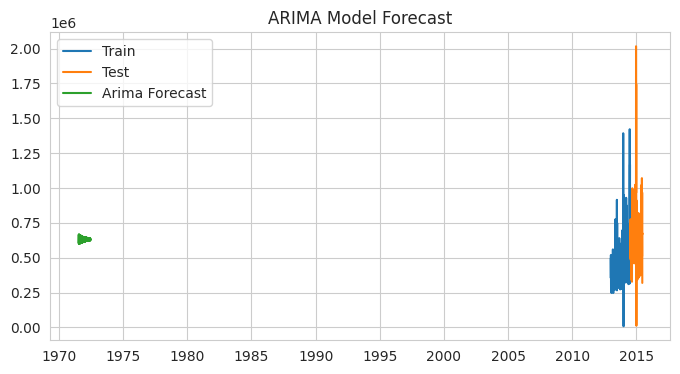

In [81]:
plt.figure(figsize=(8,4))
plt.plot(train_data['sales'], label ='Train')
plt.plot(test_data['sales'], label ='Test')
plt.plot(Arima_pred, label ='Arima Forecast')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast')
plt.show();

###### Evaluation

In [82]:
mse = mean_squared_error(test_data,Arima_pred)
msle = mean_squared_log_error(test_data, Arima_pred)
rmse =np.sqrt(mse).round(2)
rmsle =np.sqrt(msle).round(2)

results1 =pd.DataFrame([['ARIMA',mse, msle,rmse,rmsle]], columns =['Model','mse','msle','rmse','rmsle'])

results = results.append(results1,ignore_index =True)

results

,Model,mse,msle,rmse,rmsle
0,AR,"62,117,015,608.195",0.186,"249,232.850",0.430
1,ARIMA,"38,698,069,226.590",0.134,"196,718.250",0.370


##### Comment:

The ARIMA model performs better than the AR model

#### Multivariate Forecasting with Sales as dependent variable

#### Linear Model

In [83]:
# Linear Regression Model
lr = LinearRegression()
model = lr.fit(X_train, y_train)

# Make prediction on X_test
lr_predictions = lr.predict(X_test)

In [84]:
# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)

# Print the evaluation results for Linear Regression model
print("\nEvaluation Results for Linear Regression:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("RMSLE:", lr_rmsle)


Evaluation Results for Linear Regression:
MSE: 0.79
RMSE: 0.89
RMSLE: 0.28


In [85]:
from sklearn.metrics import mean_squared_error

# predict on test set
y_pred = model.predict(X_test)

# calculate MSE
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.79


#### Decision Tree Regression Model

In [86]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Make prediction on X_test
dt_predictions = dt.predict(X_test)

# Evaluation Metrics for Decision Tree Regression
dt_mse = mean_squared_error(y_test, dt_predictions).round(2)
dt_rmse = np.sqrt(dt_mse).round(2)

# Evaluation Metrics for Decision Tree Regression
dt_predictions_abs = abs(dt_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and dt_predictions_abs array
dt_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, dt_predictions_abs)).round(2)

# Print the evaluation results for Decision Tree Regression model
print("\nEvaluation Results for Decision Tree Regression:")
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)

print("RMLSE:", dt_rmsle)


Evaluation Results for Decision Tree Regression:
MSE: 0.06
RMSE: 0.24
RMLSE: 0.06


#### XGBoost Model

In [87]:
# create an instance of the XGBRegressor class
xgb_model = xgb.XGBRegressor()

# fit the model on the training data
xgb_model.fit(X_train, y_train)

# make predictions on the test data
xgb_predictions = xgb_model.predict(X_test)

In [88]:
# Evaluation Metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_predictions).round(2)
xgb_rmse = np.sqrt(xgb_mse).round(2)

#y_test_abs = abs(y_test)
xgb_predictions_abs = abs(xgb_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and xgb_predictions_abs array
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, xgb_predictions_abs)).round(2)

# Print the evaluation results for XGBoost model
print("\nEvaluation Results for XGBoost:")
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("RMSLE:", xgb_rmsle)


Evaluation Results for XGBoost:
MSE: 0.15
RMSE: 0.39
RMSLE: 0.13


#### Random Forest Regression Model

In [89]:
# Random Forest Regression Model
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)

# Make prediction on X_test
rf_predictions = rf.predict(X_test)

In [90]:
# Evaluation Metrics for Random Forest Regression
rf_mse = mean_squared_error(y_test, rf_predictions).round(2)
rf_rmse = np.sqrt(rf_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
rf_predictions_abs = abs(rf_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and rf_predictions_abs array
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, rf_predictions_abs)).round(2)

# Print the evaluation results for Random Forest Regrression model
print("\nEvaluation Results for Random Forest:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("RMSLE:", rf_rmsle)



Evaluation Results for Random Forest:
MSE: 0.04
RMSE: 0.2
RMSLE: 0.05


### Evaluation

In [94]:
# Define a table to compare evaluation results
evaluation_metrics = ['MSE', 'RMSE', 'RMSLE']
models = ['Linear Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = [[lr_mse, lr_rmse, lr_rmsle],
           [dt_mse, dt_rmse, dt_rmsle],
           [xgb_mse, xgb_rmse, xgb_rmsle],
           [rf_mse, rf_rmse, rf_rmsle]]
results_table = pd.DataFrame(data=results, columns=evaluation_metrics, index=models)

# Print the comparison table
print("Comparison Table of Evaluation Results:\n", results_table)


Comparison Table of Evaluation Results:
                     MSE  RMSE  RMSLE
Linear Regression 0.790 0.890  0.280
Decision Tree     0.060 0.240  0.060
XGBoost           0.150 0.390  0.130
Random Forest     0.040 0.200  0.050


In [92]:
import pickle

# Random Forest Regression Model
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)




In [95]:
# Save the trained Random Forest model as pickle file
with open('ml.pkl', 'wb') as file:
    pickle.dump(rf, file)

#### Comments

* From the evaluation metric summary, the decision tree model performs better than the other models